# A Tutorial of Causal Inference Under CIA-sufficiency Framework

This document implements the CIA-suffiicency framework by using the technology acceptance model (TAM) as an example. We present practical guidelines to support theoretical validation and alleviate common econometric biases in estimating average treatment effects (ATE).

<div>
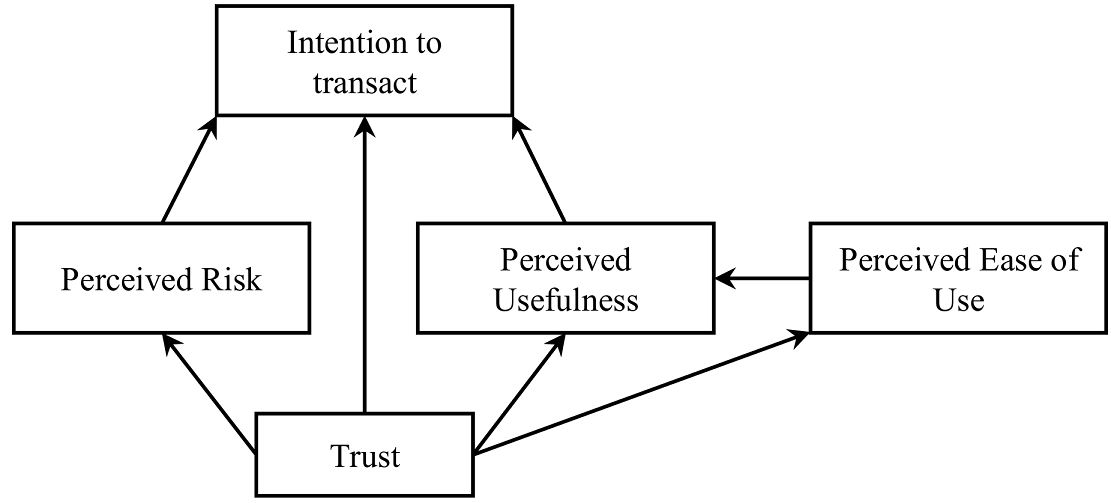
</div>

# Data: TAM Model

We test the proposed framework using a real data set with a sample size of $N = 240$ obtained from Pavlou (2003), which extended the TAM (Davis 1989) to investigate factors that drive consumers to accept e-commerce and online transactions.

In [1]:
from PCDK import estimate, PCDK
import pandas as pd
import numpy as np

# the data path of TAM
data_path = 'data/tam_consumer.xlsx'
d = pd.read_excel(data_path)
d

,TRUST1,TRUST2,TRUST3,TRUST4,FAM1,FAM2,FAM3,RISK1,RISK2,RISK3,...,White,Hisp,Asia,Afric,Gender,Education,Exper,FulTim,PartTim,NoWork
0,4.0,3.0,5.0,2.0,6.0,1.0,7.0,1.0,7,7.0,...,1,0,0,0,1.0,4.0,45.0,1,0,0
1,6.0,6.0,6.0,6.0,6.0,5.0,7.0,1.0,1,1.0,...,0,1,0,0,1.0,3.0,6.0,0,1,0
2,6.0,6.0,6.0,6.0,7.0,7.0,6.0,1.0,1,1.0,...,0,1,0,0,0.0,2.0,25.0,1,0,0
3,2.0,4.0,5.0,4.0,2.0,1.0,6.0,2.0,4,6.0,...,0,0,0,1,1.0,1.0,0.0,0,0,1
4,5.0,4.0,4.0,4.0,4.0,7.0,7.0,2.0,2,2.0,...,0,1,0,0,0.0,2.0,5.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,6.0,6.0,6.0,6.0,7.0,5.0,5.0,7.0,5,5.0,...,1,0,0,0,1.0,2.0,1.0,0,1,0
236,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7,1.0,...,0,1,0,0,1.0,3.0,3.0,0,0,1
237,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7,7.0,...,0,1,0,0,1.0,2.0,4.0,1,0,0
238,5.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,7,7.0,...,0,1,0,0,0.0,3.0,0.0,0,0,1


The major constructs like TRUST are measured by 2-4 items named as construct\#, e.g., TRUST1, TRUST2, etc.

## Preparison

We calculate the value of interested constructs by averaging the items as shown below. Readers can also consider factor analysis to measure them.

In [2]:
def categorize_tam_feature(d):
    # get the title of each feature
    titles = pd.DataFrame(d.keys()).replace('[0-9]+', '', regex=True)
    # match to feature names
    titles[1] = d.keys()
    # unique titles
    titles_u = titles[0].unique()
    # categorize feature based on title
    cates = {}
    for i in titles_u:
        cates[i] = titles[1][titles[0] == i].tolist()
    return cates
cates = categorize_tam_feature(d)
cates

{'TRUST': ['TRUST1', 'TRUST2', 'TRUST3', 'TRUST4'],
 'FAM': ['FAM1', 'FAM2', 'FAM3'],
 'RISK': ['RISK1', 'RISK2', 'RISK3', 'RISK4'],
 'INTENT': ['INTENT1', 'INTENT2', 'INTENT3'],
 'PEOU': ['PEOU1', 'PEOU2', 'PEOU3'],
 'PU': ['PU1', 'PU2', 'PU3', 'PU4', 'PU5'],
 'SAT': ['SAT1', 'SAT2', 'SAT3', 'SAT4'],
 'Age': ['Age'],
 'White': ['White'],
 'Hisp': ['Hisp'],
 'Asia': ['Asia'],
 'Afric': ['Afric'],
 'Gender': ['Gender'],
 'Education': ['Education'],
 'Exper': ['Exper'],
 'FulTim': ['FulTim'],
 'PartTim': ['PartTim'],
 'NoWork': ['NoWork']}

In [3]:
def factor_extraction(d, cates):
    comp = {}
    x = {}
    for cate in cates:
        # get the measurements
        features = cates[cate]
        x[cate] = d[features].mean(1)
    # concat and rescale to 1-7
    x = pd.DataFrame(x)
    x -= x.min(0)
    x /= x.max(0)
    x = x * 6 + 1
    return x

df = factor_extraction(d, cates)
# The interested factors
X = ['TRUST', 'RISK', 'INTENT', 'PEOU', 'PU']
df = df[X]
df

,TRUST,RISK,INTENT,PEOU,PU
0,2.578947,5.50,1.000000,5.000000,4.8000
1,5.736842,1.25,6.000000,6.666667,6.0000
2,5.736842,1.00,7.000000,7.000000,6.8000
3,2.894737,4.00,3.000000,4.333333,3.9582
4,3.526316,3.00,6.000000,6.000000,6.0000
...,...,...,...,...,...
235,5.736842,5.75,6.000000,6.000000,5.2000
236,7.000000,4.00,7.000000,7.000000,7.0000
237,7.000000,7.00,7.000000,7.000000,7.0000
238,6.368421,7.00,1.000000,7.000000,5.2000


## Case Study 1

Case study 1 investigates the causal relationship from perceived ease of use (PEOU) to perceived usefulness (PU), assuming being in the absence of the full causal knowledge of TAM.

### step 1: theoretical development

The main hypothsis is developed: 
- $H_1$: The higher the PEOU, the higher the PU.

In [4]:
# init the hypothesis by PCDK class
dag = PCDK('PEOU', 'PU')

### step 2: causal graph formation for indentifying CIA sufficiency
The prior knowledges include:
- On the basis of the theoretical foundation of the TAM (Davis 1989, Pavlou 2003), we incorporate PU $\not$ PEOU as the first prior knowledge of causal asymmetry.
- Secondly, because basic cognitive psychology indicates that behavioral factors are descendants of cognitive factors, echnology acceptance should begin from prior attitude (i.e., TRUST) to perceived values (i.e., PR, PU, PEU) to an intention (INTENT).

In [5]:
# the first causal asymmetry is automatically added when the hypothesis is initialized by PCDK 
# the second causal asymmetry can be integrated by adding a timeline as follows
dag.add_timeline(['TRUST', ['RISK', 'PEOU', 'PU'], 'INTENT'])

{('RISK', 'TRUST'): 0,
 ('PEOU', 'TRUST'): 0,
 ('PU', 'TRUST'): 0,
 ('INTENT', 'TRUST'): 0,
 ('INTENT', 'RISK'): 0,
 ('INTENT', 'PEOU'): 0,
 ('INTENT', 'PU'): 0}

Then, we can search the causal graph that is mostly consistent with the observations subject to the prior knowledge.

In [6]:
# fit the data, the order of pruned causal relationships is shown below, which is based on CI test.
G = dag.fit(df)

RISK to PEOU is pruned
TRUST to RISK is pruned, conditioned on ['PU']
TRUST to INTENT is pruned, conditioned on ['PU']
RISK to PU is pruned, conditioned on ['TRUST']
PEOU to INTENT is pruned, conditioned on ['PU']


The graph is displayed in form of adjacent matrix.

In [7]:
G

,TRUST,RISK,INTENT,PEOU,PU
TRUST,0,0,0,1,1
RISK,0,0,1,0,0
INTENT,0,0,0,0,0
PEOU,0,0,0,0,1
PU,0,0,1,0,0


The inferenced graph mostly concides with the causal relationship developed by Pavlou 2003.

In [8]:
cia_sufficiency = dag.find_cia()
cia_sufficiency

['TRUST']

That's to say, TRUST is sufficient to satisfy the CIA among the interested variables, according to the back-door criterion.

### step 3-4: model specification and estimation

Based on the sufficiency of CIA, we can estiamte the treatment effect by OLS that only controls TRUST.

In [9]:
dag.estimate_ate()

Coef.       5.035072e-01
Std.Err.    5.335619e-02
t           9.436717e+00
P>|t|       3.753751e-18
[0.025      3.983943e-01
0.975]      6.086202e-01
time        7.242918e-03
Name: PEOU, dtype: float64

The results indicate that ATE is about 0.50 (std=0.05). 

In conclusion, the key point of the CIA-sufficiency framework is to identify what we should control in model specification. Otherwise, the estimated average treatment effect might be biased and leads to misleadding implications. e.g., if we control RISK, the ATE is overestimated to 0.61 (std=0.05), as shown below.

In [10]:
# control RISK
estimate(df, 'PEOU', 'PU', ['RISK'])

Coef.       6.096289e-01
Std.Err.    4.669124e-02
t           1.305660e+01
P>|t|       1.027002e-29
[0.025      5.176460e-01
0.975]      7.016117e-01
time        6.981611e-03
Name: PEOU, dtype: float64

## Case Study 2

Following case study 1, we examine the causal effect of TRUST on INTENT, to emphasize the importance of CIA-identification. The results are shown below.

In [11]:
# init the hypothesis
dag = PCDK('TRUST', 'INTENT')
# integrating prior causal asymmetry
dag.add_timeline(['TRUST', ['RISK', 'PEOU', 'PU'], 'INTENT'])
dag.add_timeline(['PEOU', 'PU'])
# fit graph
dag.fit(df)
# identify CIA
bd = dag.find_cia()
# estimate ATE
ate = dag.estimate_ate()
# report
print(f"\nThe sufficiency of CIA is {bd}, with the estimated ATE given by \n{ate}")

RISK to PEOU is pruned
TRUST to RISK is pruned, conditioned on ['PU']
TRUST to INTENT is pruned, conditioned on ['PU']
RISK to PU is pruned, conditioned on ['TRUST']
PEOU to INTENT is pruned, conditioned on ['PU']

The sufficiency of CIA is [], with the estimated ATE given by 
Coef.       4.462590e-01
Std.Err.    6.409833e-02
t           6.962100e+00
P>|t|       3.240483e-11
[0.025      3.199864e-01
0.975]      5.725315e-01
time        4.992008e-03
Name: TRUST, dtype: float64


What's interesting is that, we should control nothing in the model specification as indicated by the CIA sufficiency. Otherwise, any abundant control variable will lead to overcontrol biases as shown below.

In [12]:
# if controlling PU
estimate(df, 'TRUST', 'INTENT', ['PU'])

Coef.       0.156954
Std.Err.    0.061949
t           2.533597
P>|t|       0.011936
[0.025      0.034913
0.975]      0.278996
time        0.007011
Name: TRUST, dtype: float64

In [13]:
# if controlling RISK
estimate(df, 'TRUST', 'INTENT', ['RISK'])

Coef.       3.848958e-01
Std.Err.    6.300585e-02
t           6.108891e+00
P>|t|       4.081780e-09
[0.025      2.607728e-01
0.975]      5.090189e-01
time        8.295536e-03
Name: TRUST, dtype: float64

## Validation and Discussion

Careful readers might find that the obtained causal graph wrongly pruned the causal direct from TRUST to RISK conditioned on PU. However, this does not stop us from correctly identifying the sufficiency of CIA for PEOU $\to$ PU in this case. To obtain more consistent causal graph based on the limited samples, each record of the pruning process (by CI test) should be examined. 

For example, the 2nd record of dag.fit, "TRUST to RISK is pruned, conditioned on ['PU']", is ridiculous as PU should not influence RISK (Formally, this causal asymmetry should be supported by literature). Hence, we can further add a causal asymmetry as follows: 

In [14]:
# the domain is collected in form of {(x1, x2) : 1 or 0}, where 1 denotes x1 -> x2, 0 denotes the asymmetry that x1 not -> x2
new_domain = {('PU', 'RISK'): 0}
# update the domain incrementally. The current domain will be returned
dag.update_domain(new_domain)

{('INTENT', 'TRUST'): 0,
 ('RISK', 'TRUST'): 0,
 ('PEOU', 'TRUST'): 0,
 ('PU', 'TRUST'): 0,
 ('INTENT', 'RISK'): 0,
 ('INTENT', 'PEOU'): 0,
 ('INTENT', 'PU'): 0,
 ('PU', 'PEOU'): 0,
 ('PU', 'RISK'): 0}

And we can obtain the identical causal graph as the Pavlou (2003).

In [15]:
G = dag.fit(df)
G

RISK to PEOU is pruned
TRUST to INTENT is pruned, conditioned on ['PU']
RISK to PU is pruned, conditioned on ['TRUST']
PEOU to INTENT is pruned, conditioned on ['PU']


,TRUST,RISK,INTENT,PEOU,PU
TRUST,0,1,0,1,1
RISK,0,0,1,0,0
INTENT,0,0,0,0,0
PEOU,0,0,0,0,1
PU,0,0,1,0,0


## Reference

Pavlou, P. A. (2003). Consumer acceptance of electronic commerce: Integrating trust
and risk with the technology acceptance model. International Journal of Electronic
Commerce, 7(3):101–134.

Davis, F. D. (1989). Perceived usefulness, perceived ease of use, and user acceptance
of information technology. MIS Quarterly, pages 319–340.